# Imports
* data link: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data

In [1]:
import numpy as np
import os
import random
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import glob as gb
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_path = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
pred_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/"

In [3]:
for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path) + folder + "/*.jpg")
    print(f"for training data, found {len(files)} in folder {folder}")

for training data, found 2512 in folder mountain
for training data, found 2382 in folder street
for training data, found 2191 in folder buildings
for training data, found 2274 in folder sea
for training data, found 2271 in folder forest
for training data, found 2404 in folder glacier


In [4]:
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path) + folder + "/*.jpg")
    print(f"for training data, found {len(files)} in folder {folder}")

for training data, found 525 in folder mountain
for training data, found 501 in folder street
for training data, found 437 in folder buildings
for training data, found 510 in folder sea
for training data, found 474 in folder forest
for training data, found 553 in folder glacier


In [5]:
files = gb.glob(pathname=str(pred_path) + "/*.jpg")
print(f"for training data, found {len(files)}")

for training data, found 7301


In [6]:
size = []
for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path) + folder + "/*.jpg")
    for file in tqdm(files):
        img = plt.imread(file)
        size.append(img.shape)

100%|██████████| 2404/2404 [00:15<00:00, 152.13it/s]


In [7]:
pd.Series(size).value_counts()

(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(144, 150, 3)        2
(143, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(108, 150, 3)        2
(136, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(100, 150, 3)        1
(141, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(147, 150, 3)        1
(131, 150, 3)        1
(81, 150, 3)         1
(140, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(149, 150, 3)        1
(110, 150, 3)        1
(105, 150, 3)        1
(97, 150, 3)         1
(120, 150, 3)        1
(76, 150, 3)         1
(119, 150, 3)        1
(102, 150, 3)        1
Name: count, dtype: int64

In [8]:
test_size = []
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path) + folder + "/*.jpg")
    for file in tqdm(files):
        img = plt.imread(file)
        test_size.append(img.shape)

100%|██████████| 553/553 [00:03<00:00, 170.18it/s]


In [9]:
pd.Series(test_size).value_counts()

(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)       1
(141, 150, 3)       1
(149, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(72, 150, 3)        1
Name: count, dtype: int64

In [10]:
pred_size = []
files = gb.glob(pathname=str(pred_path) + "/*.jpg")
for file in tqdm(files):
    img = plt.imread(file)
    pred_size.append(img.shape)

100%|██████████| 7301/7301 [00:50<00:00, 143.73it/s]


In [11]:
pd.Series(pred_size).value_counts()

(150, 150, 3)    7288
(139, 150, 3)       1
(108, 150, 3)       1
(129, 150, 3)       1
(143, 150, 3)       1
(149, 150, 3)       1
(144, 150, 3)       1
(133, 150, 3)       1
(112, 150, 3)       1
(100, 150, 3)       1
(374, 500, 3)       1
(126, 150, 3)       1
(124, 150, 3)       1
(131, 150, 3)       1
Name: count, dtype: int64

# Conclusion
* we choose 150 x 150 for image size
* encode and decode image labels

In [12]:
encode = {"buildings": 0, "forest": 1, "glacier": 2, "mountain": 3, "sea": 4, "street": 5}
decode = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
IMG_SIZE = (150, 150)
n_classes = len(encode)

# Load data function

In [13]:
def load_data(train_path, test_path):
    train_images = []
    train_labels = []
    for folder in os.listdir(train_path):
        label = encode[folder]
        for file in tqdm(os.listdir(os.path.join(train_path, folder))):
            img_path = os.path.join(os.path.join(train_path, folder), file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            train_images.append(img)
            train_labels.append(label)
    test_images = []
    test_labels = []
    for folder in os.listdir(test_path):
        label = encode[folder]
        for file in tqdm(os.listdir(os.path.join(test_path, folder))):
            img_path = os.path.join(os.path.join(test_path, folder), file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            test_images.append(img)
            test_labels.append(label)
    train_images = np.array(train_images, dtype="float32")
    train_labels = np.array(train_labels, dtype="int32")
    test_images = np.array(test_images, dtype="float32")
    test_labels = np.array(test_labels, dtype="int32")
    return train_images, train_labels, test_images, test_labels

In [14]:
X_train, y_train, X_test, y_test = load_data(train_path, test_path)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

100%|██████████| 553/553 [00:01<00:00, 352.26it/s]


((14034, 150, 150, 3), (14034,), (3000, 150, 150, 3), (3000,))

# Visualize some random samples

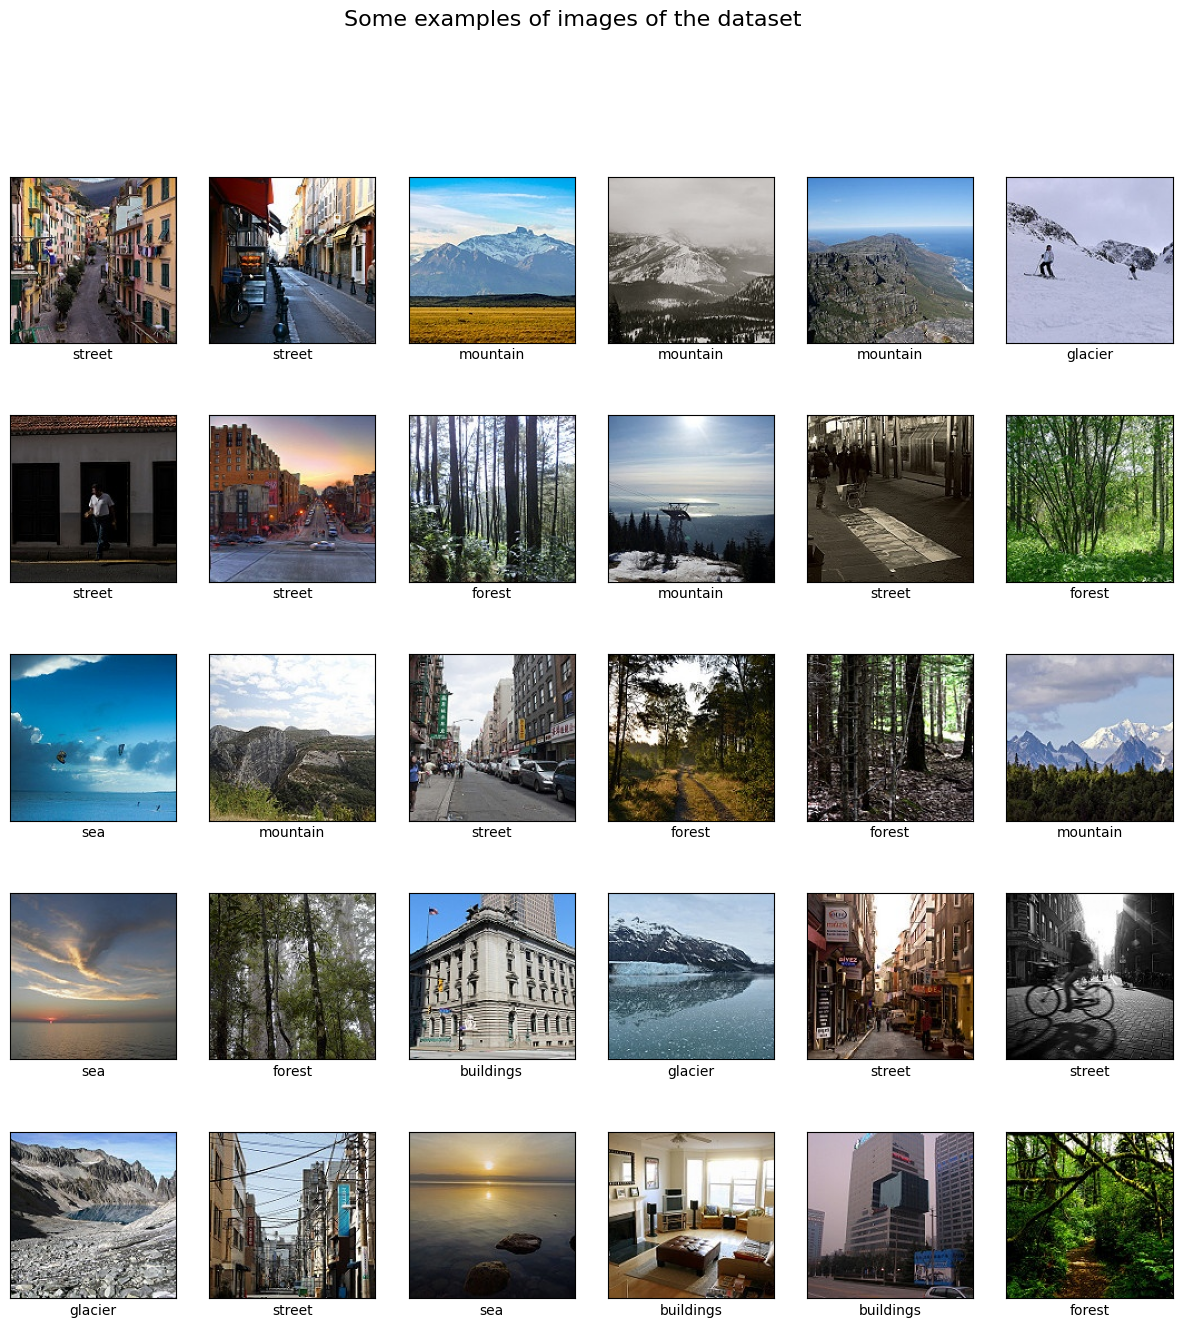

In [15]:
def display_examples(images, labels):
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    x = 1
    idx = np.random.choice(images.shape[0], 30, replace = False)
    for i in idx:
        plt.subplot(5,6,x)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i] / 255, cmap=plt.cm.binary)
        plt.xlabel(decode[labels[i]])
        x += 1
    plt.show()
display_examples(X_train, y_train)

In [16]:
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]
iddx = np.random.permutation(X_test.shape[0])
X_test = X_test[iddx]
y_test = y_test[iddx]

* Normalization

In [17]:
X_train = X_train / 255
X_test = X_test / 255

# CNN Models

In [18]:
cnn_model = tf.keras.Sequential(
    [
        # Convolutional Layer 1
        Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        # Convolutional Layer 2
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        # Convolutional Layer 3
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        # Flatten Layer
        Flatten(),
        # Fully Connected Layer 1
        Dense(128, activation="relu"),
        Dropout(0.5),  # Dropout layer to prevent overfitting
        # Output Layer
        Dense(
            n_classes, activation="softmax"
        ),  # num_classes should be the number of classes in your dataset
    ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnn_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [20]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cnn_hist = cnn_model.fit(
    X_train, y_train, epochs=20, batch_size=64, validation_split=0.2
)

Epoch 1/20


I0000 00:00:1724973215.659427     120 service.cc:145] XLA service 0x7dd338004d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724973215.659524     120 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724973215.659533     120 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/176 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.1686 - loss: 2.2478 

I0000 00:00:1724973224.098838     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.4371 - loss: 1.4316 - val_accuracy: 0.6573 - val_loss: 0.8652
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.6308 - loss: 0.9662 - val_accuracy: 0.7332 - val_loss: 0.7162
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7307 - loss: 0.7424 - val_accuracy: 0.7752 - val_loss: 0.6334
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7604 - loss: 0.6644 - val_accuracy: 0.7927 - val_loss: 0.5518
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8077 - loss: 0.5429 - val_accuracy: 0.8215 - val_loss: 0.5093
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8401 - loss: 0.4746 - val_accuracy: 0.8361 - val_loss: 0.4654
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8551 - loss: 0.4091 - val_accuracy: 0.8187 - val_loss: 0.5178
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8788 - loss: 0.3531 - val_accuracy: 0.83

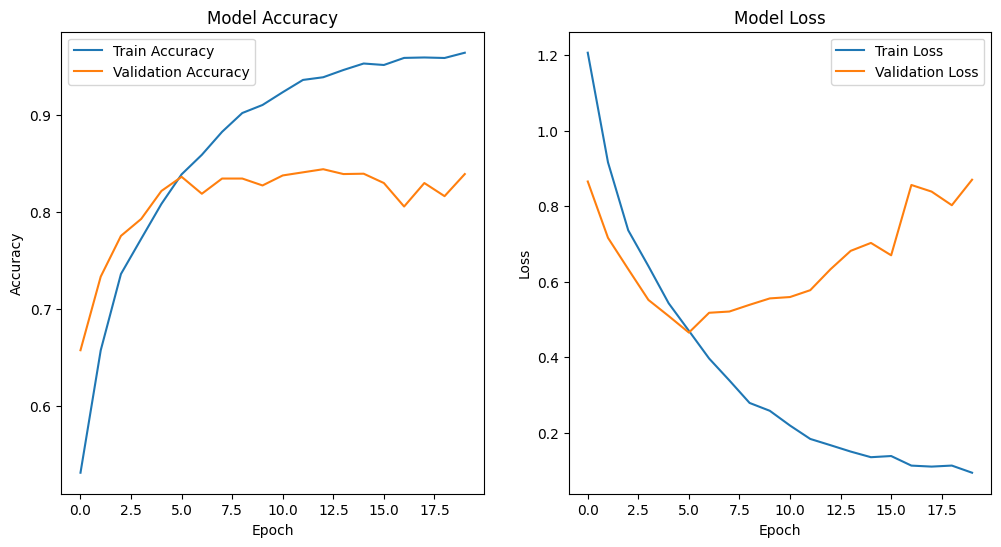

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cnn_hist.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cnn_hist.history['loss'], label='Train Loss')
plt.plot(cnn_hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.show()

In [72]:
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print("Loss = " , loss)
print("Accuracy = ", accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8331 - loss: 0.8531
Loss =  0.8467913269996643
Accuracy =  0.8383333086967468


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


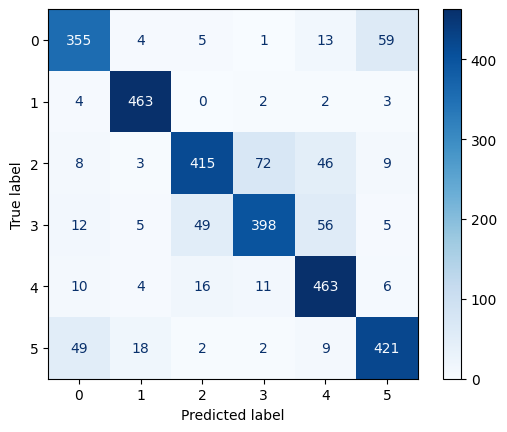

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions
predictions = cnn_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=True)

## another CNN architecture

In [23]:
cnn_model2 = Sequential(
    [
        Conv2D(200, kernel_size=(3, 3), activation="relu", input_shape=(150, 150, 3)),
        Conv2D(180, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(5, 5)),
        Conv2D(180, kernel_size=(3, 3), activation="relu"),
        Conv2D(140, kernel_size=(3, 3), activation="relu"),
        Conv2D(100, kernel_size=(3, 3), activation="relu"),
        Conv2D(50, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(5, 5)),
        Flatten(),
        Dense(180, activation="relu"),
        Dense(100, activation="relu"),
        Dense(50, activation="relu"),
        Dropout(rate=0.5),
        Dense(6, activation="softmax"),
    ]
)

In [24]:
cnn_model2.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [25]:
cnn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 200)  │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 146, 146, 180)  │       324,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 180)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 27, 27, 180)    │       291,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 140)    │       226,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 100)    │       126,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 50)     │        45,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 180)            │       144,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        18,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187,286 (4.53 MB)

 Trainable params: 1,187,286 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
cnn_hist2 = cnn_model2.fit(X_train, y_train, epochs=35, validation_split=0.30)

Epoch 1/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 148s 402ms/step - accuracy: 0.2967 - loss: 1.6026 - val_accuracy: 0.6257 - val_loss: 0.9451
Epoch 2/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step - accuracy: 0.5739 - loss: 1.0685 - val_accuracy: 0.6659 - val_loss: 0.8817
Epoch 3/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 91s 296ms/step - accuracy: 0.6312 - loss: 0.9330 - val_accuracy: 0.6808 - val_loss: 0.8441
Epoch 4/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 91s 295ms/step - accuracy: 0.6715 - loss: 0.8522 - val_accuracy: 0.7193 - val_loss: 0.7272
Epoch 5/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 90s 294ms/step - accuracy: 0.7137 - loss: 0.7896 - val_accuracy: 0.7409 - val_loss: 0.6868
Epoch 6/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 90s 294ms/step - accuracy: 0.7425 - loss: 0.7108 - val_accuracy: 0.6785 - val_loss: 0.8296
Epoch 7/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 90s 293ms/step - accuracy: 0.7637 - loss: 0.6679 - val_accuracy: 0.7554 - val_loss: 0.6432
Epoch 8/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 90s 293ms/step - accuracy: 0.7931 - loss: 

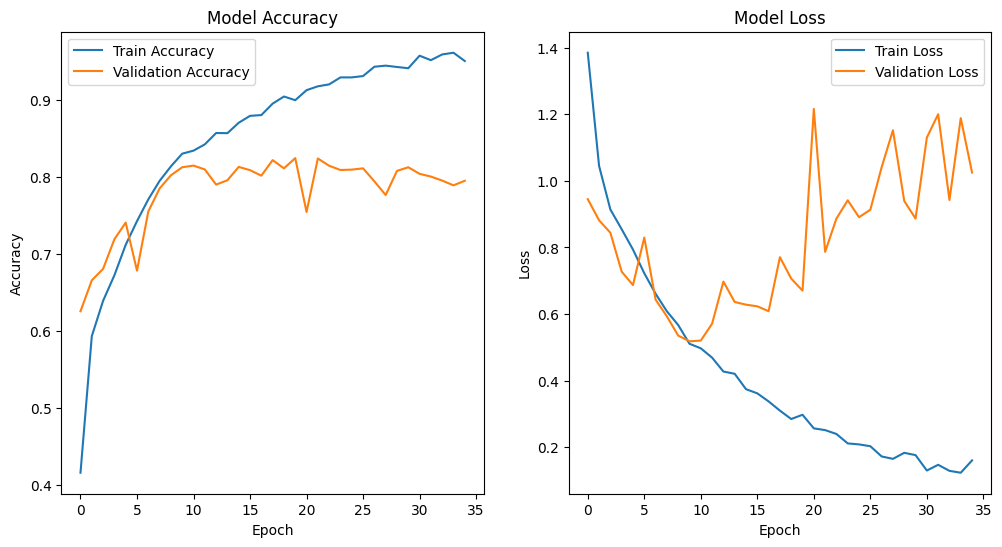

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cnn_hist2.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_hist2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(cnn_hist2.history['loss'], label='Train Loss')
plt.plot(cnn_hist2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.show()

* there is overfitting let's try more compelx models

# VGG-16

In [30]:
from tensorflow.keras.applications import VGG16

pretrained_model = VGG16(
    input_shape=(150, 150, 3), include_top=False, weights="imagenet"
)

for layer in pretrained_model.layers:
    layer.trainable = False

pretrained_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [36]:
from tensorflow.keras import layers
from tensorflow.keras import Model
last_layer = pretrained_model.get_layer("block5_pool")
print("last layer of vgg : output shape: ", last_layer.output)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(6, activation="softmax")(x)

vgg_model = Model(pretrained_model.input, x)

last layer of vgg : output shape:  <KerasTensor shape=(None, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_44>


In [39]:
from tensorflow.keras.optimizers import RMSprop
vgg_model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
)

In [42]:
vgg_hist = vgg_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20


2024-08-30 00:40:07.423988: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[128,256,37,37]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,37,37]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-30 00:40:07.580416: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.156556856s
Trying algorithm eng12{k11=2} for conv (f32[128,256,37,37]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,256,37,37]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operatio

88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 776ms/step - acc: 0.9683 - loss: 0.1043 - val_acc: 0.8839 - val_loss: 0.3364
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 324ms/step - acc: 0.9731 - loss: 0.0934 - val_acc: 0.8810 - val_loss: 0.3395
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 324ms/step - acc: 0.9744 - loss: 0.0843 - val_acc: 0.8735 - val_loss: 0.3747
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 322ms/step - acc: 0.9791 - loss: 0.0765 - val_acc: 0.8764 - val_loss: 0.3739
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 324ms/step - acc: 0.9730 - loss: 0.0857 - val_acc: 0.8764 - val_loss: 0.3665
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 323ms/step - acc: 0.9799 - loss: 0.0721 - val_acc: 0.8774 - val_loss: 0.3753
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 321ms/step - acc: 0.9802 - loss: 0.0682 - val_acc: 0.8810 - val_loss: 0.3721
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 324ms/step - acc: 0.9865 - loss: 0.0567 - val_acc: 0.8685 - val_loss: 0.4044
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 323ms/step - acc:

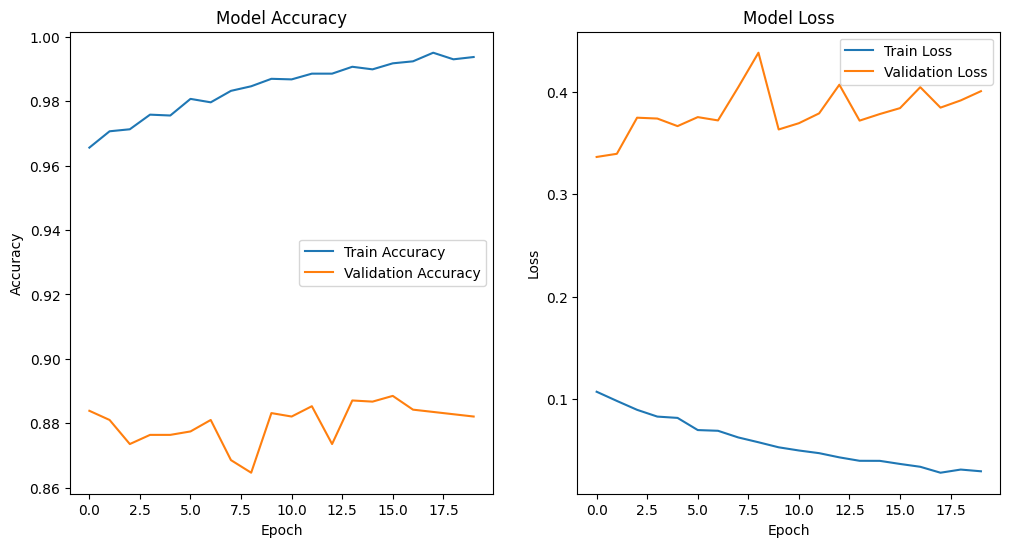

In [47]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(vgg_hist.history['acc'], label='Train Accuracy')
plt.plot(vgg_hist.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(vgg_hist.history['loss'], label='Train Loss')
plt.plot(vgg_hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.show()

In [48]:
loss, accuracy = vgg_model.evaluate(X_test, y_test)
print("Loss = " , loss)
print("Accuracy = ", accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - acc: 0.8827 - loss: 0.3892
Loss =  0.3853852450847626
Accuracy =  0.8833333253860474


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step


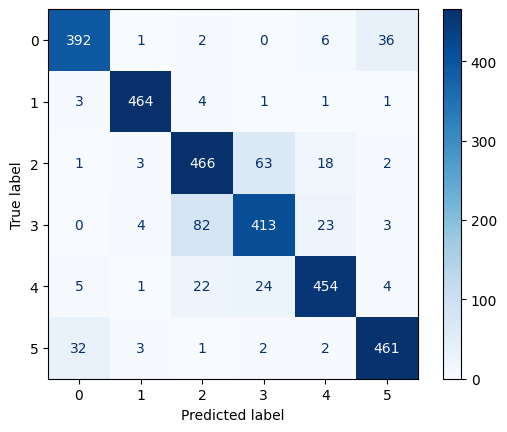

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions
predictions = vgg_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=True)

## saving the model

In [59]:
vgg_model.save("VGG16_model.h5", include_optimizer=True)

# ResNet-50

In [60]:
from tensorflow.keras.applications import ResNet50

pretrained_model = ResNet50(
    input_shape=(150, 150, 3), include_top=False, weights="imagenet"
)

for layer in pretrained_model.layers:
    layer.trainable = False

pretrained_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [61]:
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of resnet : output shape: ', last_layer.output)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense(6, activation='softmax')(x)

resnet_model = Model(pretrained_model.input, x) 

last layer of vgg : output shape:  <KerasTensor shape=(None, 5, 5, 2048), dtype=float32, sparse=False, name=keras_tensor_261>


In [62]:
resnet_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [67]:
resnet_hist = resnet_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.6111 - loss: 0.9563 - val_accuracy: 0.6815 - val_loss: 0.8443
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.6225 - loss: 0.9325 - val_accuracy: 0.6772 - val_loss: 0.8328
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.6160 - loss: 0.9357 - val_accuracy: 0.6826 - val_loss: 0.8303
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step - accuracy: 0.6087 - loss: 0.9420 - val_accuracy: 0.6762 - val_loss: 0.8647
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 0.5874 - loss: 0.9819 - val_accuracy: 0.6840 - val_loss: 0.8124
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.6020 - loss: 0.9465 - val_accuracy: 0.6961 - val_loss: 0.8199
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.6012 - loss: 0.9418 - val_accuracy: 0.6722 - val_loss: 0.8368
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.6014 - loss: 0.9582 - val_accu

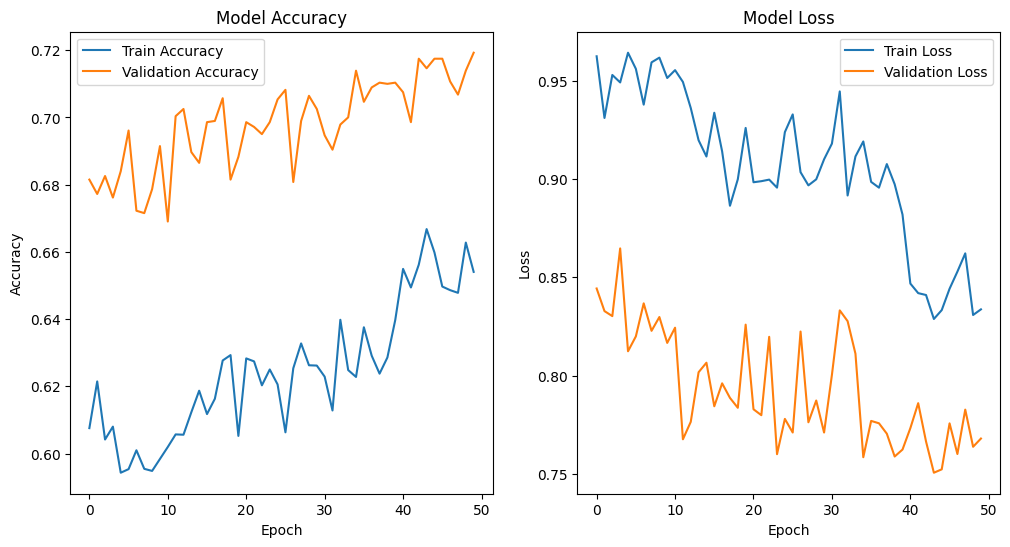

In [68]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(resnet_hist.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(resnet_hist.history['loss'], label='Train Loss')
plt.plot(resnet_hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.show()

In [69]:
loss, accuracy = resnet_model.evaluate(X_test, y_test)
print("Loss = " , loss)
print("Accuracy = ", accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6935 - loss: 0.8019
Loss =  0.8044232726097107
Accuracy =  0.7003333568572998


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


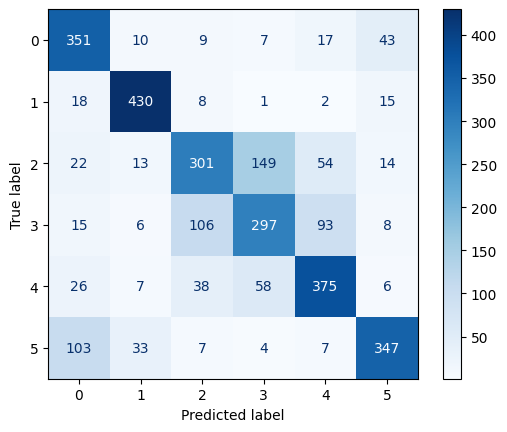

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions
predictions = resnet_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=True)

## saving the model

In [71]:
resnet_model.save("ResNet50_model.h5", include_optimizer=True) # 724 MB take care

# Conclusion

* VGG-16 (88.33%) on test accuracy, it is the best model and we can train more for better accuracy
* Simple CNN (83.8%) on test accuracy, maybe we can use data augmentaion and increase its size and more epochs will be good
* ResNet-50 (70%) on test accuracy, it is better for complex datasets not for this data because it's archetichutre is very complex